### Audio Load by Barney

In [1]:
from barney_functions import *
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import soundfile as sf
import itertools
from sklearn.metrics import confusion_matrix

# Load Zebra Audio

In [2]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
audio_files, audio_size, index_longest = gen_audio_array(audio_path,df)
y = df['label']

Finding longest file (Better Labels)


100%|█████████████████████████████████████████| 413/413 [00:08<00:00, 47.78it/s]


Loading files


100%|█████████████████████████████████████████| 413/413 [00:07<00:00, 55.99it/s]


In [3]:
y = df['label']

# Load Non Zebra Audio

In [4]:
nzebra_path = 'big bounce small.wav'
nzebra_audio, labels_nzebra = gen_nzebra(nzebra_path,audio_size)

Padding


100%|███████████████████████████████████████| 718/718 [00:00<00:00, 5373.73it/s]


In [5]:
# Combine zebra and non zebra
all_audio, y_all = add_nzebra(audio_files,y,nzebra_audio,labels_nzebra)

In [6]:
print(all_audio.shape)
print("Unaugmented dataset size: ",all_audio.nbytes/(1e9), 'GB')

(1131, 39923)
Unaugmented dataset size:  0.361223304 GB


In [7]:
num_classes_all = len(np.unique(y_all))
num_classes = len(np.unique(y))

# Augment Data

In [8]:
augmented_audio = augment_audio_faster_smaller(audio_files)

Augmenting 413 samples


100%|████████████████████████████████████████| 413/413 [00:01<00:00, 376.31it/s]


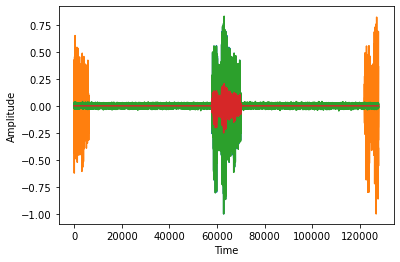

In [9]:
plot_sample(augmented_audio,100)

In [10]:
stfts = calc_stft(augmented_audio)

Augmentation  1


100%|████████████████████████████████████████| 413/413 [00:02<00:00, 142.50it/s]


Augmentation  2


100%|████████████████████████████████████████| 413/413 [00:02<00:00, 140.00it/s]


Augmentation  3


100%|████████████████████████████████████████| 413/413 [00:02<00:00, 161.35it/s]


Augmentation  4


100%|████████████████████████████████████████| 413/413 [00:02<00:00, 147.87it/s]


In [11]:
stfts_1D = np.zeros(stfts[0].shape)
stfts_1D = stfts[0]
for i in tqdm(range(1,stfts.shape[0])):
    stfts_1D = np.concatenate((stfts_1D,stfts[i]), axis = 0)
print("Augmented dataset size: ",stfts_1D.nbytes/(1e9), 'GB')

100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.75s/it]

Augmented dataset size:  3.3866 GB


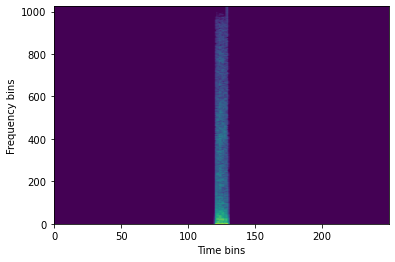

In [24]:
spec_plot(stfts_1D[400,:,:])

### Data preparation

In [13]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [14]:
from sklearn.model_selection import KFold

In [32]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=32,
                     kernel_size=8,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=(img_rows, img_cols, 1)))
    model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Dropout(rate=0.40))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])
        
    return model

In [33]:
n_folds = 2
n_epochs = 1
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_loss = np.zeros((n_folds,n_epochs))
X = stfts[0]
y = y 
check_class_complete(kfold,X,y)

Check complete.


In [34]:
fold_no = 1
for train_index, test_index in kfold.split(X, y):
    
    print("-----------------------------------")
    print("FOLD "+str(fold_no))
    print("-----------------------------------")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # save for scaling test data
    mu_train = np.mean(X_train)
    sigma_train = np.std(X_train)

    # Standardize pixel distribution to have zero mean and unit variance
    train_images = standardizeimg(img=X_train, mu=mu_train, sigma=sigma_train)
    val_images = standardizeimg(img=X_test, mu=np.mean(X_test), sigma=np.std(X_test))

    # adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
    img_rows, img_cols = X_train.shape[1], X_train.shape[2] # input image dimensions
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

    # convert class vectors to binary class matrices - one hot encoding
    onehot_t = pd.get_dummies(y_train)
    label_list = onehot_t.columns
    y_train = onehot_t.to_numpy()

    onehot_v = pd.get_dummies(y_test)
    y_test = onehot_v.to_numpy()
    
    model = create_model()

    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=n_epochs,
                        verbose=1,
                        validation_data=(X_test, y_test))
    
    fold_loss[fold_no-1] = history.history['val_categorical_accuracy']
    fold_no += 1

-----------------------------------
FOLD 1
-----------------------------------
2/2 [==============================] - 60s 25s/step - loss: 1.6618 - categorical_accuracy: 0.1359 - val_loss: 1.2550 - val_categorical_accuracy: 0.3865
-----------------------------------
FOLD 2
-----------------------------------
2/2 [==============================] - 61s 25s/step - loss: 1.2807 - categorical_accuracy: 0.4010 - val_loss: 1.1140 - val_categorical_accuracy: 0.7573


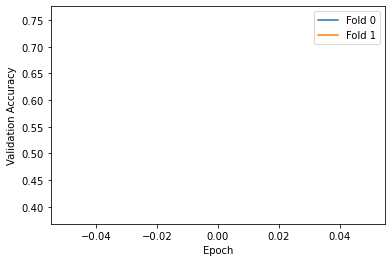

Mean Validation Accuracy:  0.5718774795532227


In [35]:
for i in range(n_folds):
    plt.plot(fold_loss[i],label=("Fold "+str(i)))
plt.xlabel("Epoch")
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()
mean_val_acc = np.mean(fold_loss[:,-1])
print("Mean Validation Accuracy: ",mean_val_acc)

1st convolution layer:


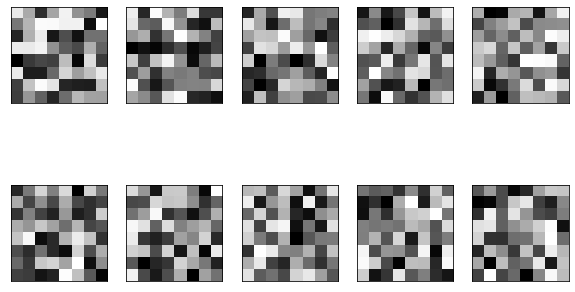

2nd convolution layer:


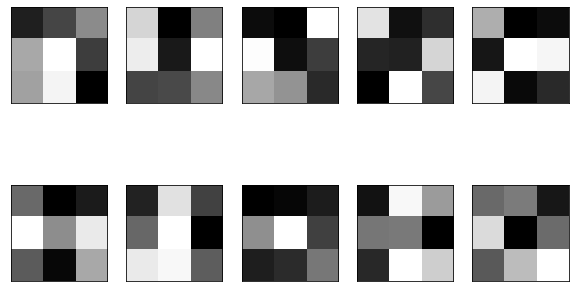

In [36]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

print('1st convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

print('2nd convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Evaluation

3/3 - 2s - loss: 0.7913 - categorical_accuracy: 0.9024 - 2s/epoch - 741ms/step


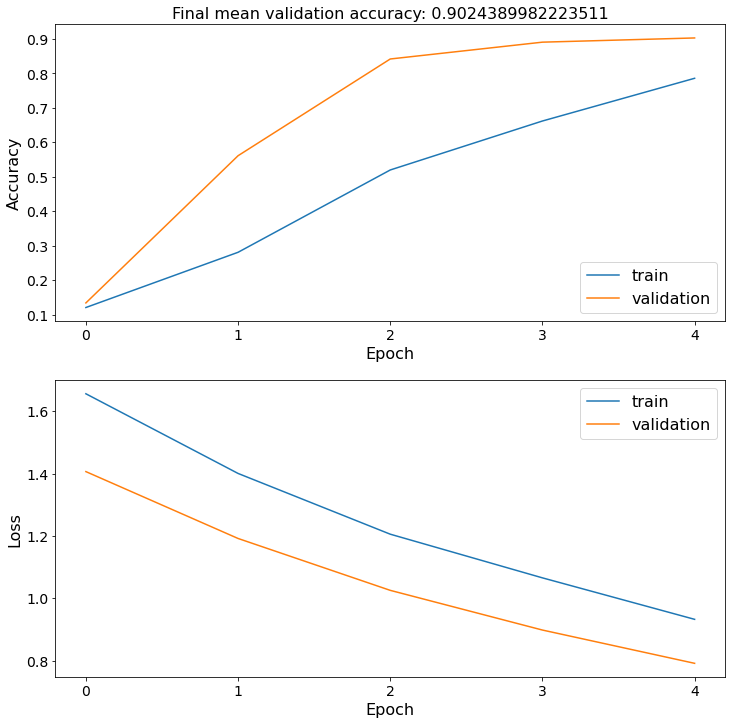

In [20]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

### Inference

In [21]:
# using until now unseen data
predicted_prob = model.predict(X_test)
predictions = np.argmax(predicted_prob, axis=1)

In [22]:
predicted_prob.shape

(82, 4)

[[50  0  0  0]
 [ 3  0  0  0]
 [ 4  0  1  0]
 [ 1  0  0 23]]


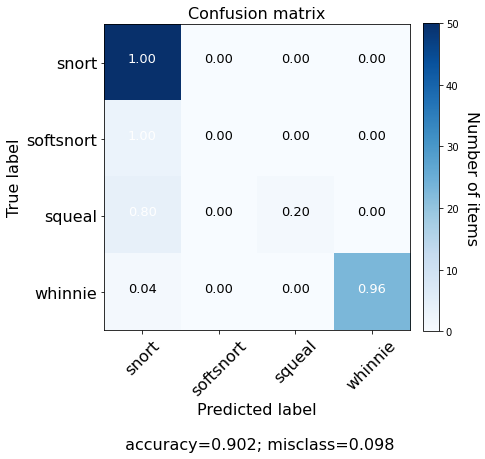

In [23]:
labels_list = np.unique(y)
onehot_v = pd.get_dummies(y)
onehot_y = np.repeat(onehot_v.to_numpy(),4,axis=0)
truths = np.argmax(y_test, axis=1)
cm = confusion_matrix(truths, predictions, labels=range(num_classes))
print(cm)
plot_confusion_matrix(cm,labels_list)